
## Run this notebook to DEPLOY A NEW ENDPOINT

### Limits

We can't deploy too many endpoints 

In [2]:
# %%capture
# import IPython
# import sys

# !{sys.executable} -m pip install ipywidgets
# IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used

In [36]:
!python -m pip install --upgrade pip --quiet
!pip install -U awscli --quiet
!pip install -U sagemaker --quiet

In [37]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
import boto3
import datetime
import time
from time import strftime,gmtime
import json
import os
import urllib
import sys
import io
import logging

# This code will be loaded on each worker separately..
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

role = get_execution_role()
boto_session = boto3.session.Session()
sm_session = sagemaker.session.Session()
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")
sns_client = boto3.client('sns')
region = boto_session.region_name
bucket = sm_session.default_bucket()
prefix = 'async-inference-maskrcnn'

print(region)
print(role)
print(bucket)
print(prefix)

us-east-1
arn:aws:iam::438093652407:role/TeamRole
sagemaker-us-east-1-438093652407
async-inference-maskrcnn


In [38]:
!pip3 install -r dev_requirements.txt

Looking in links: --extra-index-url
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-wwmusaar
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-wwmusaar
  Resolved https://github.com/huggingface/diffusers to commit bbab8553224d12f7fd58b0e65b0daf899769ef0b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download the model locally archive and upload to S3

In [39]:
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline,EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
model = StableDiffusionInstructPix2PixPipeline.from_pretrained(
model_id, torch_dtype=torch.float16, safety_checker=None)
print(type(model))
model.scheduler = EulerAncestralDiscreteScheduler.from_config(model.scheduler.config)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


<class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline'>


In [62]:
!mkdir model_and_code
torch.save(model, 'model_and_code/model.pth')
!mkdir model_and_code/code
!cp ./code/* model_and_code/code
!tar cvzf model.tar.gz -C model_and_code/ . 

cp: -r not specified; omitting directory './code/__pycache__'
./
./model.pth
./code/
./code/requirements.txt
./code/inference.py
./code/__init__.py


In [63]:
from sagemaker.s3 import S3Uploader
file_key = 'model.tar.gz'
model_artifact = S3Uploader.upload(file_key,'s3://{}/{}/model'.format(bucket, prefix))
print(model_artifact)

s3://sagemaker-us-east-1-438093652407/async-inference-maskrcnn/model/model.tar.gz


## Create SageMaker model with PyTorch inference container

### Decide on the image to use

In [64]:
from sagemaker.image_uris import retrieve

# 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
# 763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.19.0-deepspeed0.7.3-cu113
# 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker

deploy_instance_type = 'ml.g4dn.xlarge'
pytorch_inference_image_uri = "763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker"


# other option
#pytorch_inference_image_uri = retrieve('pytorch',
#                                       region,
#                                       version='1.11.0',
#                                       py_version='py38',
#                                       instance_type = 'ml.g4dn.xlarge',
#                                       accelerator_type=None,
#                                       image_scope='inference')

print(pytorch_inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker


In [65]:
container = pytorch_inference_image_uri
model_name = 'sagemaker-pix2pix-{0}'.format(str(int(time.time())))
print(container)
print(model_name)

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': container,
        'ModelDataUrl': model_artifact,
        'Environment': {
            'TS_MAX_REQUEST_SIZE': '100000000', #default max request size is 6 Mb for torchserve, need to update it to support the 70 mb input payload
            'TS_MAX_RESPONSE_SIZE': '100000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }
    },    
)

763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker
sagemaker-pix2pix-1678574454


# Real time hosted endpoint deployment and inference

Create an endpoint config name. Here we create one based on the date so it we can search endpoints based on creation time.

## Config

In [66]:
print(model_name)
endpoint_config_name = f"maskrcnnEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1
        }
    ]
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

sagemaker-pix2pix-1678574454
Created EndpointConfig: arn:aws:sagemaker:us-east-1:438093652407:endpoint-config/maskrcnnendpointconfig-2023-03-11-22-40-54


## Deploy

In [67]:
endpoint_name = f"sm-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)

In [68]:
### YOU WILL NEED THIS FOR TESTING => store it

print(endpoint_name)

sm-2023-03-11-22-40-55


# Call endpoint

In [69]:
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


# Test endpoint

In [70]:
import json
import base64

with open("data/input/venus-of-milo-512.jpg", "rb") as image2string:
        base64_bytes  = base64.b64encode(image2string.read())

# pass it as string for json
base64_string = base64_bytes.decode('utf-8')
    

model_inputs = {'prompt': "Turn her to a cyborg",
            'image': base64_string,
            'steps': 20,
            'image_cfg_scale': 1.3,
            'text_cfg_scale': 7,
            'num_images_per_prompt': 1,
}
request_body = {"model_inputs": model_inputs}
payload = json.dumps(request_body, indent=2)

In [85]:
%timeit
ep= endpoint_name
sm_runtime = boto3.Session().client('sagemaker-runtime')
r = sm_runtime.invoke_endpoint(EndpointName=ep, Body=payload)
stream = r['Body'].read()

In [86]:
res = json.loads(stream)

AttributeError: 'list' object has no attribute 'keys'

In [87]:
print(res[0]["text_cfg_scale"], res[0]["image_cfg_scale"])

7 1.4


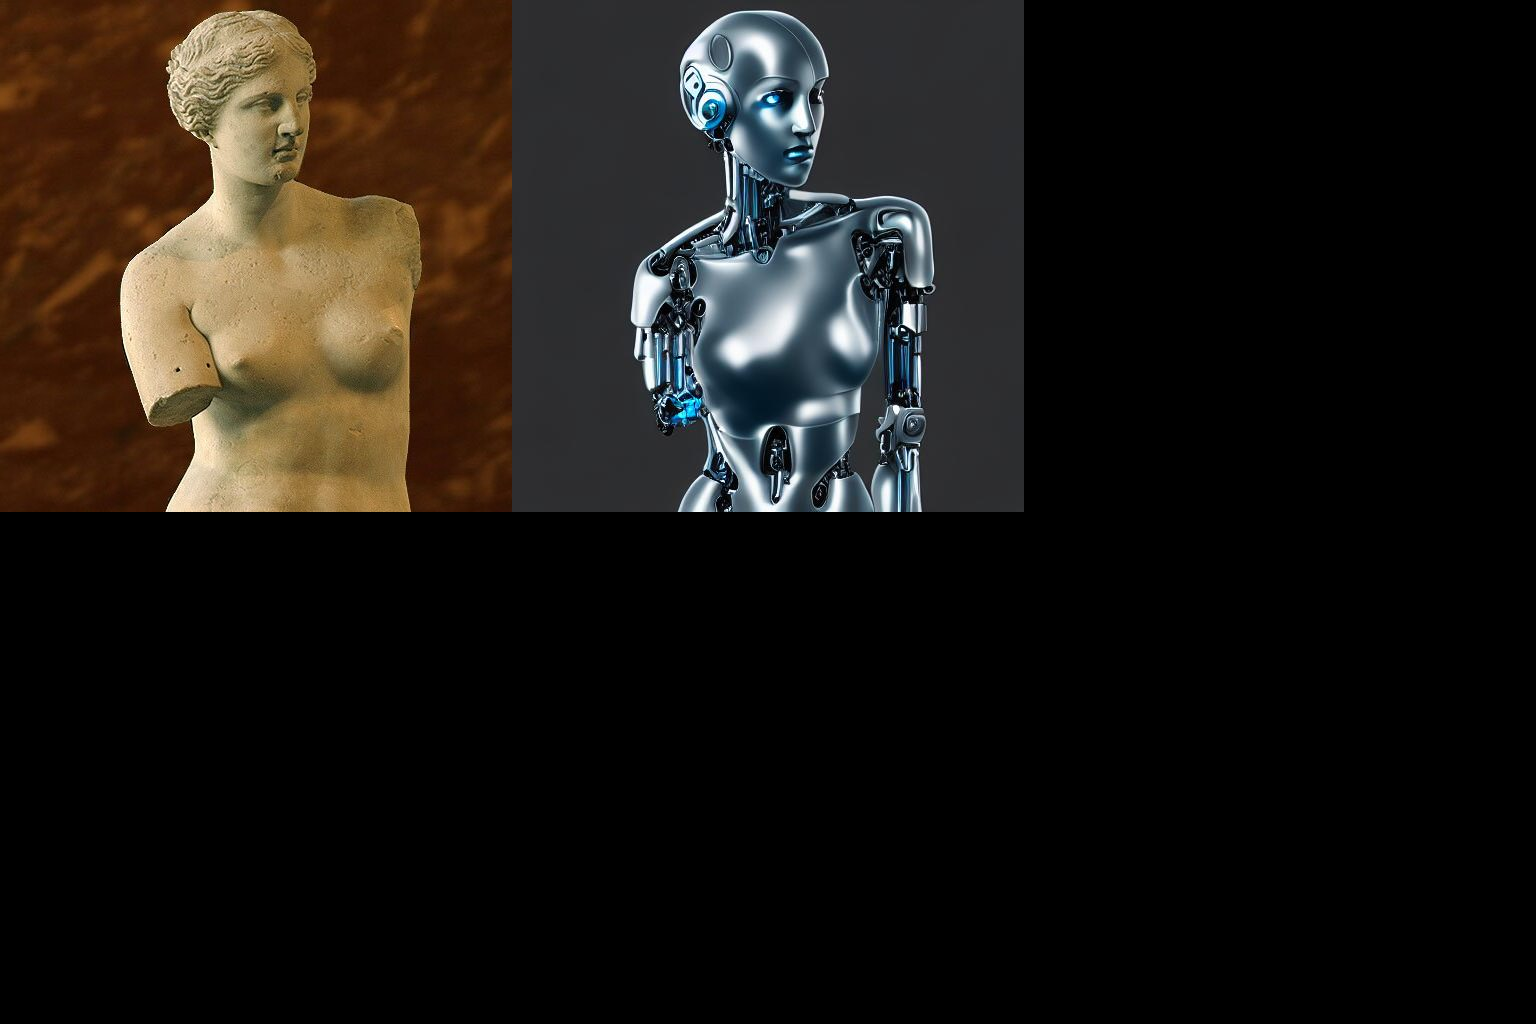

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import base64

def _stringToPil(
    img_string: str
    ):
    is_data_url = True if len(img_string.split(",")) > 1 else False
    
    if is_data_url:
        base64string = img_string.split(",")[1]
    else:
        base64string = img_string

    img = Image.open(BytesIO(base64.b64decode(base64string,
         validate=True))).convert("RGB")
    return img

def image_grid(imgs, rows, cols):

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

imgs = []
imgs.append(_stringToPil(base64_string))
for i, sample in enumerate(res):
    imgs.append(_stringToPil(sample["image"]))
    
    
image_grid(imgs, 2, 3)

### Delete the endpoint if its shit

In [ ]:
# sm_client.delete_endpoint(EndpointName=endpoint_name)